# Analysis of multi-omics data of chronic lymphocytic leukemia patients

In [ ]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
import scanpy as sc
import muon as mu
import pandas as pd
import seaborn as sns
import mofax as mfx
import matplotlib.pyplot as plt

### Load Data

"Here, we measured ex vivo sensitivity of 246 blood cancers to 63 drugs alongside genome, transcriptome, and DNA methylome analysis to understand determinants of drug response. We assembled a primary blood cancer cell encyclopedia data set that revealed disease-specific sensitivities for each cancer. Within chronic lymphocytic leukemia (CLL), responses to 62% of drugs were associated with 2 or more mutations, and linked the B cell receptor (BCR) pathway to trisomy 12, an important driver of CLL. Based on drug responses, the disease could be organized into phenotypic subgroups characterized by exploitable dependencies on BCR, mTOR, or MEK signaling and associated with mutations, gene expression, and DNA methylation. Fourteen percent of CLLs were driven by mTOR signaling in a non–BCR-dependent manner. Multivariate modeling revealed immunoglobulin heavy chain variable gene (IGHV) mutation status and trisomy 12 as the most important modulators of response to kinase inhibitors in CLL. Ex vivo drug responses were associated with outcome. This study overcomes the perception that most mutations do not influence drug response of cancer, and points to an updated approach to understanding tumor biology, with implications for biomarker discovery and cancer care."

A detailed explanation of the data can be found here: https://www.jci.org/articles/view/93801 

In [3]:
mrna = pd.read_csv("data/cll_mrna.csv", index_col=0).T
drugs = pd.read_csv("data/cll_drugs.csv", index_col=0).T
mutations = pd.read_csv("data/cll_mutations.csv", index_col=0).T
methylation = pd.read_csv("data/cll_methylation.csv", index_col=0).T
metadata = pd.read_csv("data/cll_metadata.csv", index_col=0)

print(f"RNA Shape: {mrna.shape}")
print(f"Drugs Shape: {drugs.shape}")
print(f"Mutations Shape: {mutations.shape}")
print(f"Methylation Shape: {methylation.shape}")
print(f"Metadata Shape: {metadata.shape}")

RNA Shape: (136, 5000)
Drugs Shape: (200, 310)
Mutations Shape: (200, 69)
Methylation Shape: (200, 4248)
Metadata Shape: (265, 10)


In [4]:
gene_ids = pd.read_csv("data/cll_gene_ids.csv", index_col=0)
cols = list(mrna.columns)

# Replace each value in cols with the corrsponding value in the gene_ids dataframe
cols = [gene_ids.loc[gene_ids["GENEID"] == gene, "SYMBOL"].item() for gene in cols]
mrna.columns = cols

mutations.columns = [f"m_{x}" for x in mutations.columns]

In [59]:
import numpy as np
mutations[:, mutations.var.index == "m_IGHV"].to_df().isna().sum()

m_IGHV    12
dtype: int64

In [45]:
metadata.IGHV.value_counts(dropna=False)

M      110
U       86
NaN     69
Name: IGHV, dtype: int64

### Data Properties

#### RNA

In [5]:
mrna.head()

,HBB,PPP1R9A,SH3BGRL2,LPL,CNTNAP2,HBA2,SEPT10,ZNF471,ZNF667,RBMS3,...,BRIP1,MGST3,NAGS,FAM229B,ZNF491,CDK2AP1,GJB2,BSN,LDHD,CCDC38
H045,4.558644,11.741854,8.921456,12.686458,2.644946,2.644946,11.473792,9.680574,10.323723,11.137333,...,7.220013,10.177649,4.667130,7.052534,6.323287,10.059942,1.528848,5.771337,1.528848,5.256267
H109,2.721512,13.287432,2.721512,10.925985,12.648355,1.528848,10.271483,9.986980,10.231973,1.528848,...,7.947078,8.223803,4.775046,6.279164,5.799820,10.361200,1.528848,5.359180,2.383843,7.360436
H024,9.938456,2.341006,12.381452,1.528848,1.528848,6.664661,3.408744,3.657904,3.657904,2.341006,...,8.967320,10.096502,5.815616,6.369060,6.539086,8.152703,1.528848,6.059008,2.341006,5.715771
H056,13.278004,3.232874,8.106266,1.528848,13.565210,9.580385,3.410471,3.565827,3.232874,2.417160,...,8.532982,10.238564,5.902633,5.728777,5.929667,7.737858,2.417160,5.495087,3.232874,5.789100
H079,6.086874,11.940820,4.889503,13.340588,5.476914,3.862678,9.955379,10.244702,10.567114,7.967849,...,7.760580,8.790501,5.929477,5.833956,6.036300,8.274131,2.270282,5.102382,1.528848,6.316072


#### Drugs

The mapping of Drug ID to Compound and Main Target can be found in App. 6 here: https://www.jci.org/articles/view/93801/sd/1

In [6]:
drugs.head()

,D_001_1,D_001_2,D_001_3,D_001_4,D_001_5,D_002_1,D_002_2,D_002_3,D_002_4,D_002_5,...,D_172_1,D_172_2,D_172_3,D_172_4,D_172_5,D_CHK_1,D_CHK_2,D_CHK_3,D_CHK_4,D_CHK_5
H045,0.023639,0.046233,0.318747,0.823703,0.896278,0.094328,0.416996,0.684516,0.705886,0.635737,...,0.085584,0.817506,1.1,1.100000,1.046411,1.056821,1.100000,1.040568,0.993331,0.989254
H109,0.073599,0.106230,0.273289,0.717138,0.885000,0.172113,0.504201,0.702193,0.750747,0.746797,...,0.101792,0.827360,1.1,1.100000,1.100000,1.023215,1.100000,1.037670,1.012460,0.957553
H024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H056,0.058139,0.090220,0.232215,0.722574,0.795750,0.187089,0.767374,1.070742,1.032205,1.100000,...,0.501332,0.909873,1.1,1.100000,1.050284,0.915873,1.093643,1.100000,1.074945,1.040403
H079,0.020421,0.047505,0.363896,0.807391,0.879489,0.117735,0.529514,0.788220,0.824481,0.788881,...,0.128200,0.821278,1.1,1.087701,1.022566,1.048188,1.100000,1.100000,1.100000,1.100000


<Axes: >

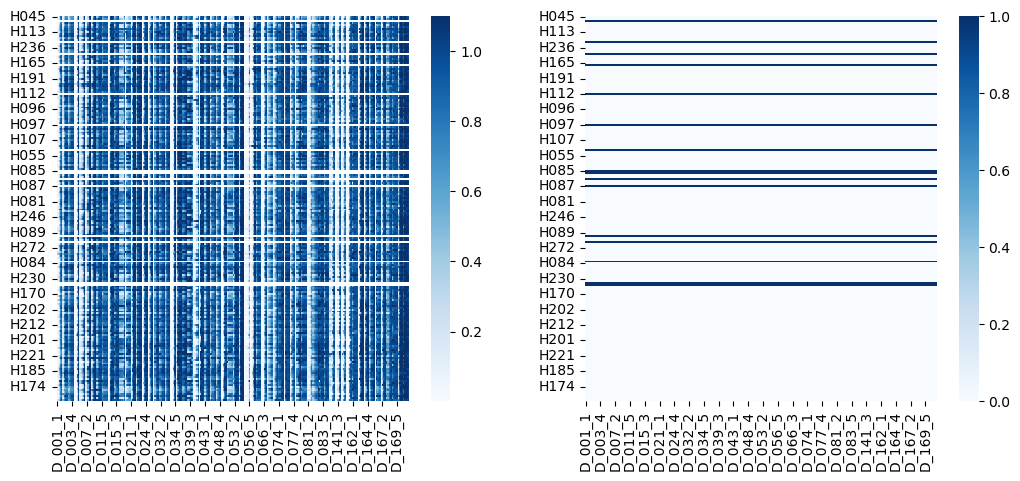

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
sns.heatmap(drugs, ax=ax[0], cmap="Blues")
sns.heatmap(drugs.isna(), ax=ax[1], cmap="Blues")

#### Metadata

In [8]:
metadata.head()

# T5: time (in years) which passed from taking the sample to the next treatment (TTT)
# T6: time (in years) which passed from taking the sample to patients’ death (TTD)

,Diagnosis,Gender,IGHV,Age4Main,T5,T6,treatedAfter,died,IC50beforeTreatment,ConsClust
Sample,,,,,,,,,,
H001,hMNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H002,hMNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H003,hMNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H005,CLL,m,M,75.265753,0.574949,2.625599,True,False,False,IP
H006,CLL,m,M,NaN,NaN,NaN,NaN,NaN,NaN,HP


### Preprocessing

AnnData documentation: https://anndata.readthedocs.io/en/latest/

In [9]:
mrna = sc.AnnData(mrna)
methylation = sc.AnnData(methylation)
drugs = sc.AnnData(drugs)
mutations = sc.AnnData(mutations)

#### RNA

In [10]:
# Select highly variable genes
sc.pp.highly_variable_genes(mrna, n_top_genes=1000)
mrna = mrna[:, mrna.var.highly_variable]

<Axes: >

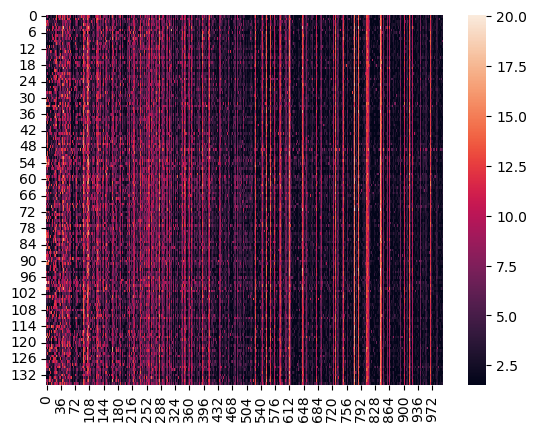

In [11]:
sns.heatmap(mrna.X)

### Create MUON object

In [12]:
mods = {
    "mrna": mrna,
    "methylation": methylation,
    "drugs": drugs,
    "mutations": mutations,
}

mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(metadata)
mdata

MuData object with n_obs × n_vars = 200 × 5627
  obs:	'Diagnosis', 'Gender', 'IGHV', 'Age4Main', 'T5', 'T6', 'treatedAfter', 'died', 'IC50beforeTreatment', 'ConsClust'
  4 modalities
    mrna:	136 x 1000
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    methylation:	200 x 4248
    drugs:	200 x 310
    mutations:	200 x 69

### MOFA

Selected arguments:
- n_factors: number of factors
- likelihoods: likelihood per view (options are “gaussian”, “poisson”, “bernoulli”). Default is guessed from the data.
- ard_weights: use ARD prior on the weights? Default is TRUE if using multiple views.
- ard_factors: use ARD prior on the factors? Default is TRUE if using multiple groups.
- spikeslab_weights: use spike-slab sparsity prior in the weights? default is TRUE.
- spikeslab_factors: use spike-slab sparsity prior in the factors? default is FALSE.
- convergence_mode: fast, medium, or slow convergence 
- use_obs: optional: strategy to deal with samples (cells) not being the same across modalities ("union" or "intersection")

#### Questions

1) What about missing data points?
2) What likelihoods should we pass to the model? Is it a problem, if we chose an incorrect one?
3) How can we finde a good number of factors?

In [13]:
mu.tl.mofa(
    mdata,
    use_obs="union",
    n_factors=10,
    convergence_mode="medium",
    outfile="models/cll_v2.hdf5",
    save_metadata=True,
    save_data=True,
    verbose=False,
    # likelihoods=["gaussian", "gaussian", "gaussian", "gaussian"],  # Would this be a good idea?
)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='mrna' group='group1' with N=200 samples and D=1000 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...


Model options:
- Automatic Relevance Determination prior on the f

# Analysis and Interpretation of the Results

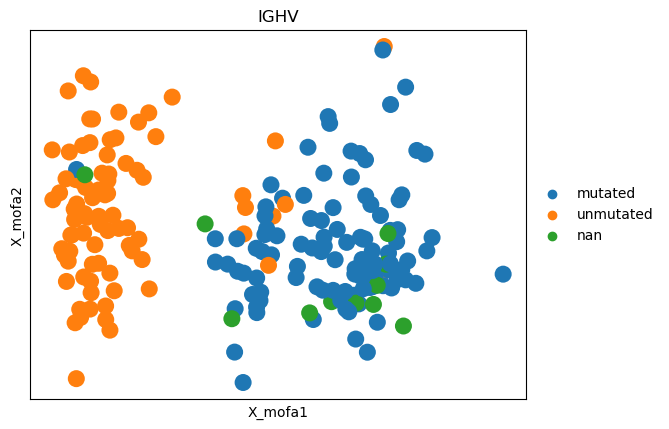

In [14]:
# Scatter plot in MOFA factors coordinates

mdata.obs.IGHV = (
    mdata.obs.IGHV.astype(str)
    .astype("category")
    .cat.rename_categories({"M": "mutated", "U": "unmutated"})
)
mu.pl.mofa(mdata, color="IGHV")

In [15]:
# Load the model with mofax
model = mfx.mofa_model("models/cll_v2.hdf5")
model

MOFA+ model: cll v2
Samples (cells): 200
Features: 5627
Groups: group1 (200)
Views: drugs (310), methylation (4248), mrna (1000), mutations (69)
Factors: 10
Expectations: W, Z

##### Weights & Factors

Text(0.5, 1.0, 'Weights')

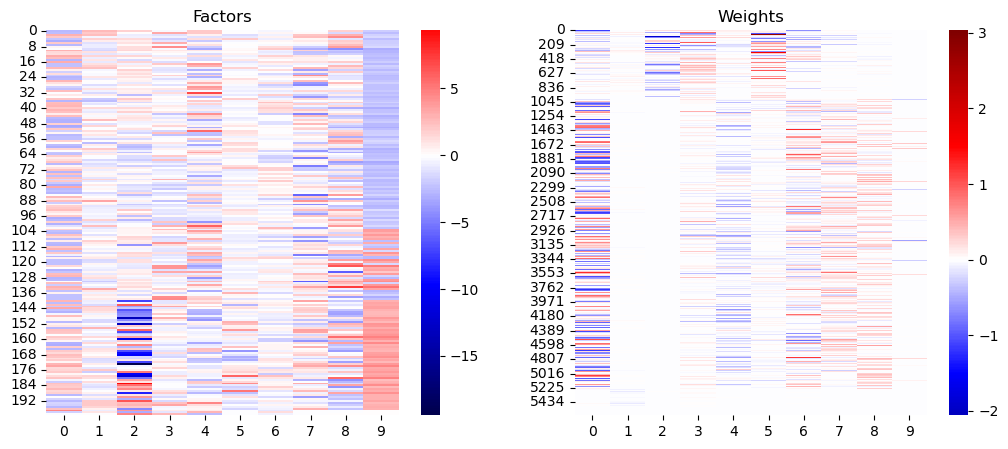

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
sns.heatmap(model.get_factors(), ax=ax[0], cmap="seismic", center=0)
sns.heatmap(model.get_weights(), ax=ax[1], cmap="seismic", center=0)
ax[0].set_title("Factors")
ax[1].set_title("Weights")

##### Factor Correlation

A good sanity check is to verify that the Factors are largely uncorrelated. In MOFA there are no orthogonality constraints such as
in Principal Component Analysis, but if there is a lot of correlation between Factors this suggests a poor model fit. Reasons?
Perhaps you used too many factors or perhaps the normalisation is not adequate.

<Axes: >

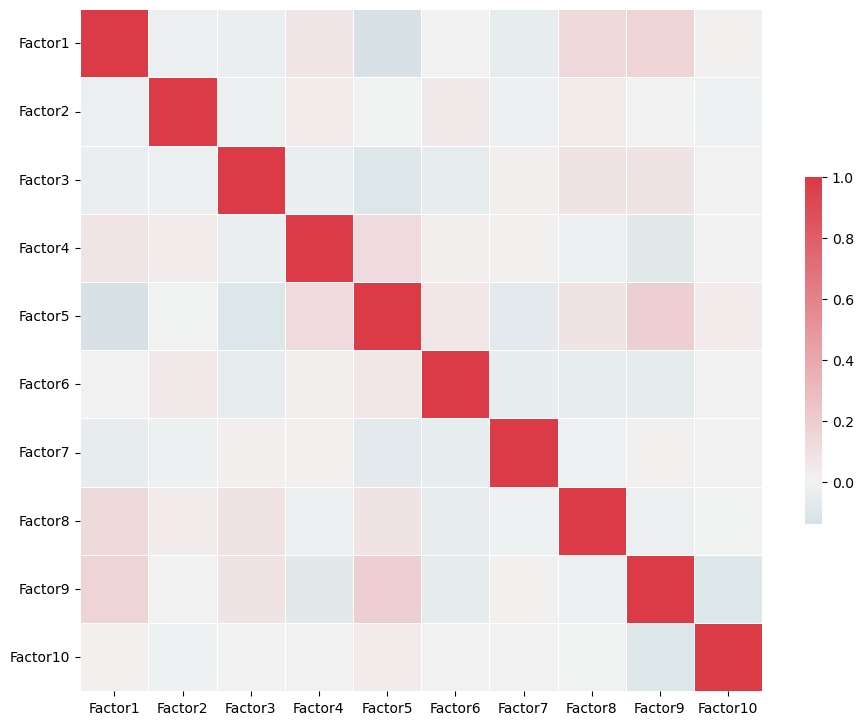

In [17]:
mfx.plot_weights_correlation(model)

#### Variance Explained

The most important insight that MOFA generates is the variance decomposition analysis. This plot shows the percentage of
variance explained by each factor across each data modality (and group, if provided). It summarises the source
of variation from a complex heterogeneous data set in a single figure.

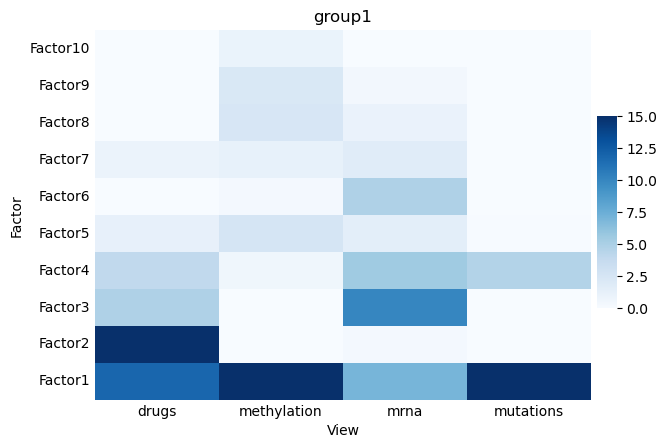

In [18]:
mfx.plot_r2(model, vmax=15, x="View")

What insights from the data can we learn just from inspecting this plot?

    Factor 1 captures a source of variability that is present across all data modalities. Thus, its etiology is likely to be something very important for the disease
    Factor 2 captures a very strong source of variation that is exclusive to the drug response data.
    Factor 4 captures variation that is present across multiple data modalities, except for DNA methylation. This is likely to be important too.
    Factor 3 is capturing some co-variation between the mRNA and the drug response assay.


#### Questions:
The higher the number of samples the _________ the total variance explained.    
The higher the number of factors, the _________ the total variance explained.

While trying to annotate factors, a global overview of top features defining them could be helpful.

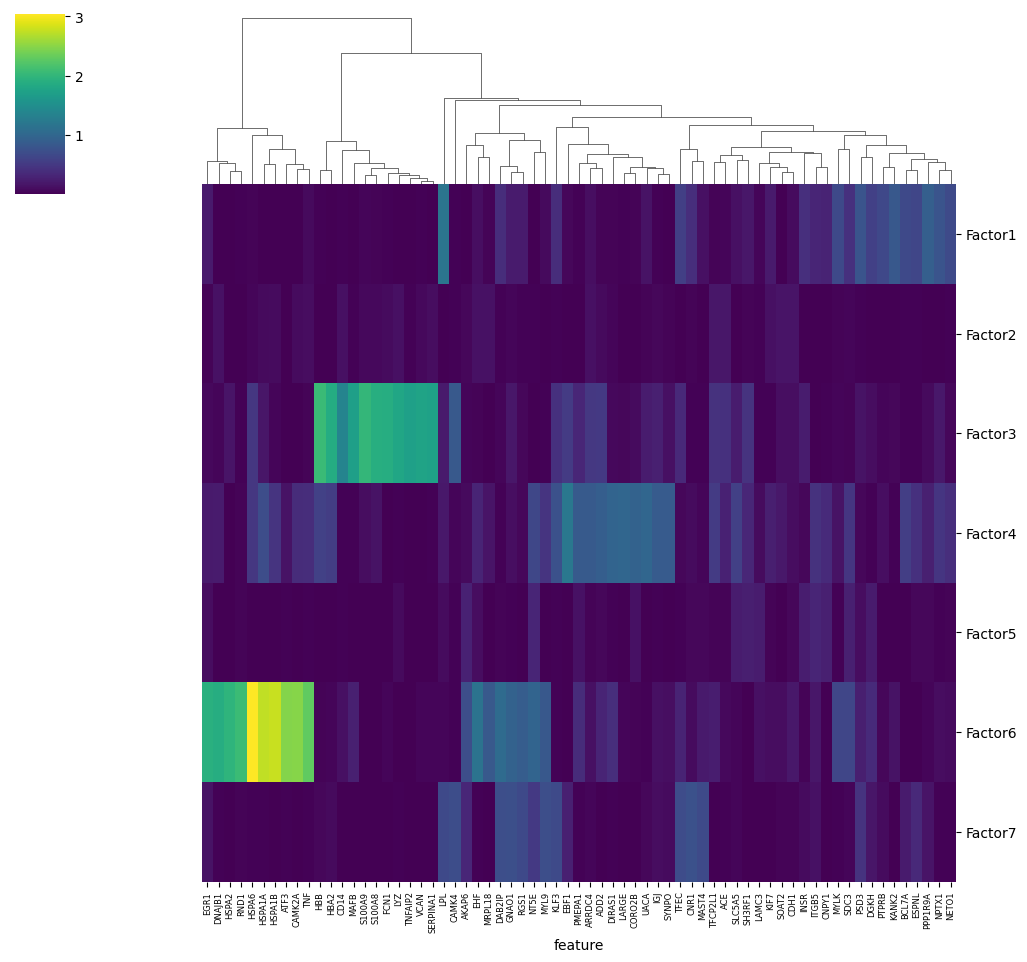

In [19]:
mfx.plot_weights_heatmap(
    model,
    # n_features=5,
    factors=range(0, 7),
    xticklabels_size=6,
    w_abs=True,
    cmap="viridis",
    cluster_factors=False,
)

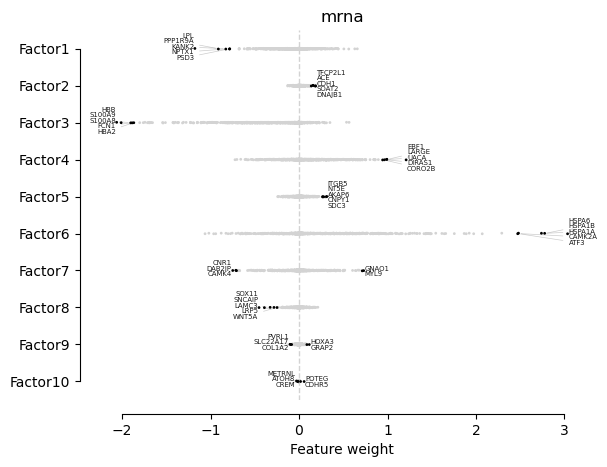

In [20]:
ax = mfx.plot_weights(
    model,
    views="mrna",
    factor=0,
    n_features=5,
    y_repel_coef=0.04,
    x_rank_offset=-150,
)

### Analysis: Factor 1 | "Give it a Name"

Ways to understande the underlying signal of a factor:  
    - association between the metadata and the factor values  
    - inspection of factor values  
    - inspection of feature weights  
    - GSEA of the weights  

Each factor captures a different source of variability in the data. Mathematically, each Factor is defined by a linear combination of the input features. Each Factor ordinates cells along a one-dimensional axis that is centered at zero. Samples with different signs manifest opposite phenotypes along the inferred axis of variation, with higher absolute value indicating a stronger effect.
Note that the interpretation of MOFA factors is analogous to the interpretation of the principal components in PCA.

<Axes: >

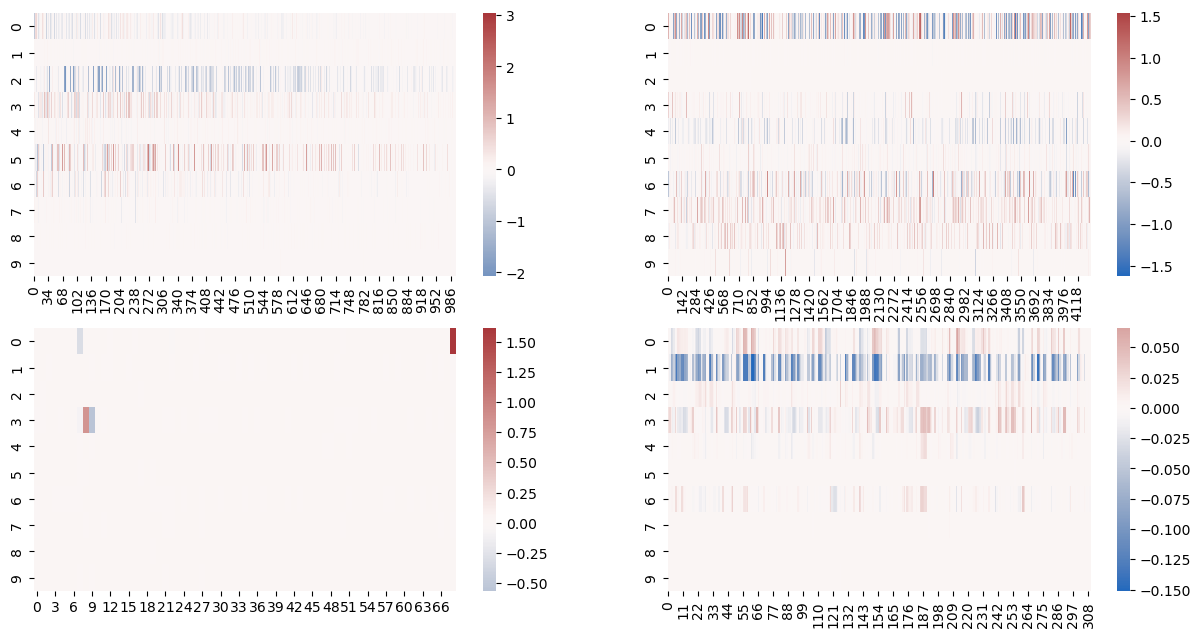

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7.5))
sns.heatmap(model.get_weights(["mrna"]).T, center=0, cmap="vlag", ax=ax[0, 0])
sns.heatmap(model.get_weights(["methylation"]).T, center=0, cmap="vlag", ax=ax[0, 1])
sns.heatmap(model.get_weights(["mutations"]).T, center=0, cmap="vlag", ax=ax[1, 0])
sns.heatmap(model.get_weights(["drugs"]).T, center=0, cmap="vlag", ax=ax[1, 1])

How do we interpret the factor values?
Each factor captures a different source of variability in the data. Mathematically, each Factor is defined by a linear combination of the input features. As the data is centered prior to running MOFA, each Factor ordinates cells along a one-dimensional axis that is centered at zero. Samples with different signs manifest opposite phenotypes along the inferred axis of variation, with higher absolute value indicating a stronger effect. Note that the interpretation of MOFA factors is analogous to the interpretation of the principal components in PCA.

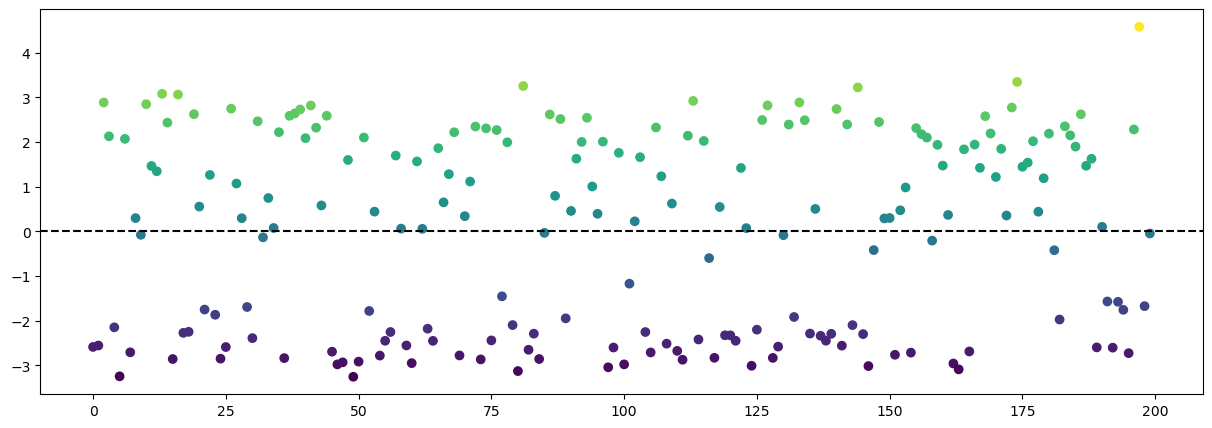

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
weights_fac_0 = model.get_factors(df=True).iloc[:, 0]
plt.scatter(range(200), weights_fac_0, c=weights_fac_0)
ax.axhline(0, color="k", linestyle="--")

By looking at the variance explained plot, we saw that Factor 1 captures variation in all data modalities. Out of all omics, the somatic mutation data is a good place to start, as somatic mutations are very sparse, easy to interpret and any change in the DNA is likely to have downstream consequences to all other molecular layers. Let’s plot the weights:

Notice that most features lie at zero, indicating that most features have no association with Factor 1. There is however one gene that clearly stands out: IGHV (immunoglobulin heavy chain variable region). This is the main clinical marker for CLL.



<Axes: title={'center': 'mutations'}, xlabel='Feature weight'>

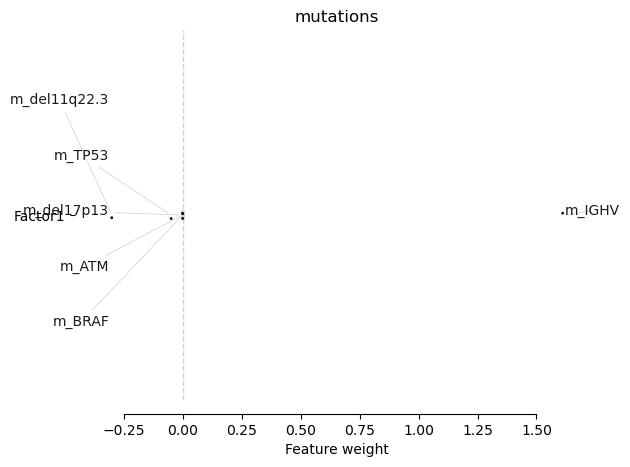

In [23]:
mfx.plot_weights(
    model,
    views=["mutations"],
    factors=0,
    zero_line=True,
    ncols=1,
    label_size=10,
    n_features=6,
)

IGHV has a positve weight. This means that samples with positive Factor 1 values have IGHV mutation whereas samples with negative Factor 1 values do not have the IGHV mutation. To confirm this, let’s plot the Factor values and colour the IGHV mutation status.

<Axes: xlabel='IGHV', ylabel='Factor1'>

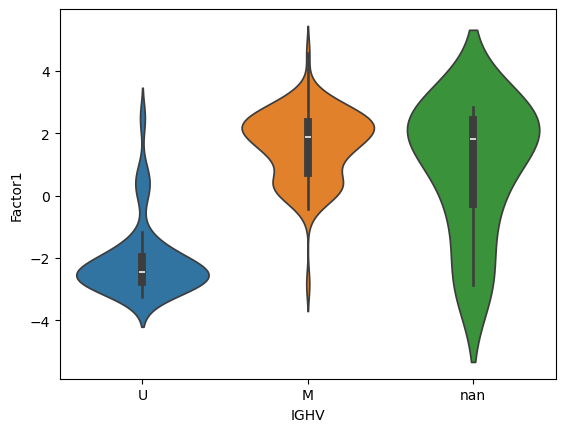

In [24]:
df_plot = pd.merge(
    model.get_factors(df=True).iloc[:, 0],
    model.metadata.IGHV,
    left_index=True,
    right_index=True,
)

sns.violinplot(x="IGHV", y="Factor1", data=df_plot, hue="IGHV")

From the variance explained plot we know that Factor 1 drives variation across all data modalities. Let’s visualise the mRNA expression changes that are associated with Factor 1:

<Axes: title={'center': 'mrna'}, xlabel='Feature weight'>

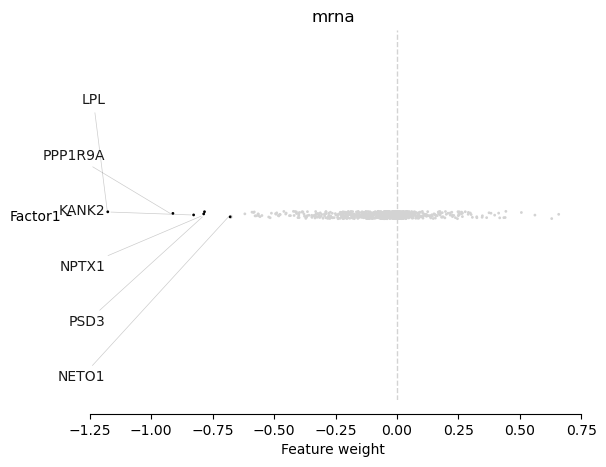

In [25]:
mfx.plot_weights(
    model,
    views=["mrna"],
    factors=0,
    zero_line=True,
    ncols=1,
    label_size=10,
    n_features=6,
)

<Axes: xlabel='IGHV', ylabel='Factor1'>

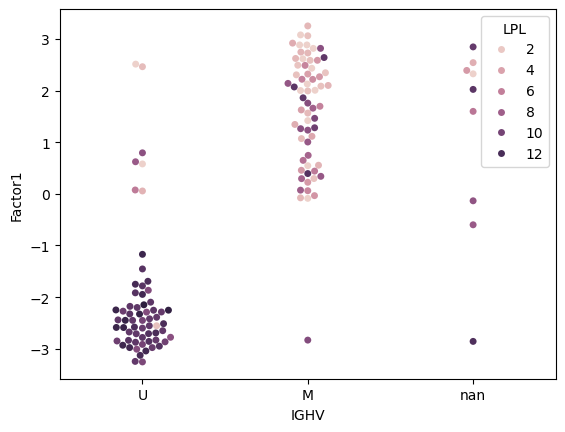

In [26]:
# Plot distribution of LPL for different IGHV status
df_plot = pd.merge(
    model.get_factors(df=True).iloc[:, 0],
    model.metadata.IGHV,
    left_index=True,
    right_index=True,
)
# Join the expression of LPL gene for each sample
df_plot = pd.merge(
    df_plot,
    pd.DataFrame({"LPL": mrna[:, "LPL"].X.squeeze()}, index=mrna.obs.index),
    left_index=True,
    right_index=True,
)

sns.swarmplot(x="IGHV", y="Factor1", data=df_plot, hue="LPL")

<Axes: title={'center': 'drugs'}, xlabel='Feature weight'>

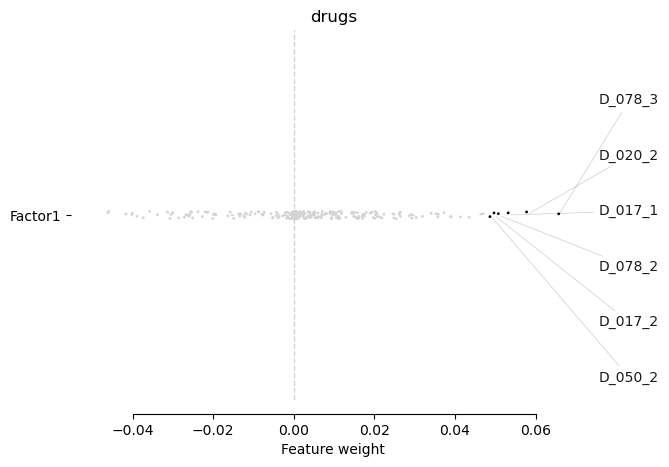

In [27]:
mfx.plot_weights(
    model,
    views=["drugs"],
    factors=0,
    zero_line=True,
    ncols=1,
    label_size=10,
    n_features=6,
)

"Indeed, the strongest associations of response with IGHV status were observed for dasatinib
and for 3 of the drugs already discussed above, the HSP90 inhibitor
AT13387 and the CHEK inhibitors PF477736 and AZD7762. These
results show how the critical role of BCR signaling renders CLL
cells sensitive to a broad range of kinase inhibitors that act by mul-
tiple target engagement of BCR components." from https://www.huber.embl.de/pub/pdf/Dietrich2018.pdf 

Focusing on the drug response, we notice PF477736 (D_078), AZD7762 (D_020), AT13387 (D_017), and dasatinib (D_050) have the major association with this factor. Those are the exact top associations with the IGHV status described in the original paper:

<Axes: title={'center': 'IGHV'}, xlabel='Factor1', ylabel='Factor3'>

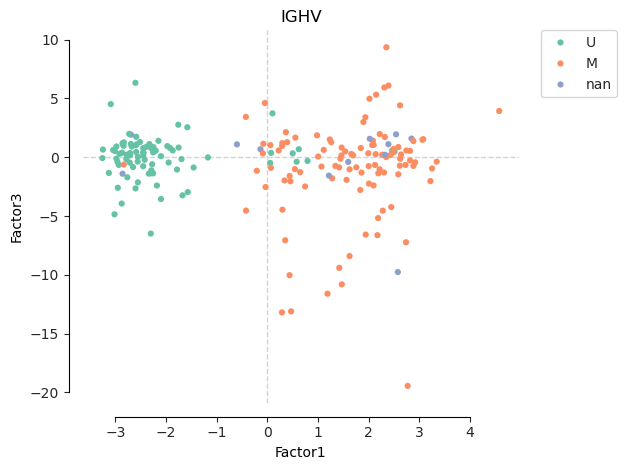

In [28]:
mfx.plot_factors(
    model,
    x=0,
    y=2,
    color=["IGHV"],
    size=20,
    zero_line_x=True,
    zero_line_y=True,
    palette="Set2",
)

### GSEA

Run: `$ conda install -c bioconda gseapy`

### End

In [29]:
# it's always a good idea to close the model after using it
model.close()

## Tasks

1) Impute the missing values in IGHV (and Trisomy12) status. Plot Fac1 vs Fac3 values and color all samples according to IGHV status/imputed.
2) Implement a predictive model to estimate the
   - [optional] survival probability (died),
   - treatedAfter and
   - time-until-treatment (TTT)   
   given the patient's (i) multi-omics data and (ii) the MOFA factors.  
   (2a) Build a model that imputed the drug responses doing the same as above.
3) Interpretation of other factors (2,3) and (4,5) together with trisomy12.
4) Meta-Analyis:
   - What factors are correlated with the other covariates?
   - What is the effect of different likelihoods?
   - What is the impact of centering and factors on the model behaviour?
   - Plot a histogram of the true rna expression distribution vs the reconstructed RNA expression. What do you notice?
5) Perform a GSEA
